# **AI in Healthcare: Building a Life-Saving Heart Disease Predictor (Without Pipelines)**

**Import Libraries & Load Dataset**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import kagglehub

# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load dataset
file_path = f"{path}/heart_disease_uci.csv"
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [34]:
df.describe()


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [35]:
df.isna().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


**Target Distribution**

/tmp/ipython-input-687353982.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="num", data=df, palette="Set2")


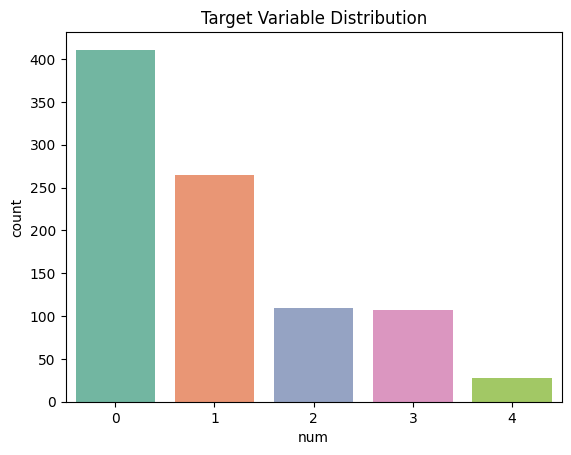

In [36]:
sns.countplot(x="num", data=df, palette="Set2")
plt.title("Target Variable Distribution")
plt.show()

**Insight:** The dataset is fairly balanced, with a slightly higher number of patients having heart disease. This is good because it means our model will have a similar number of examples for both classes to learn from, and accuracy will be a meaningful metric.

**Analysing Features v/s Target**

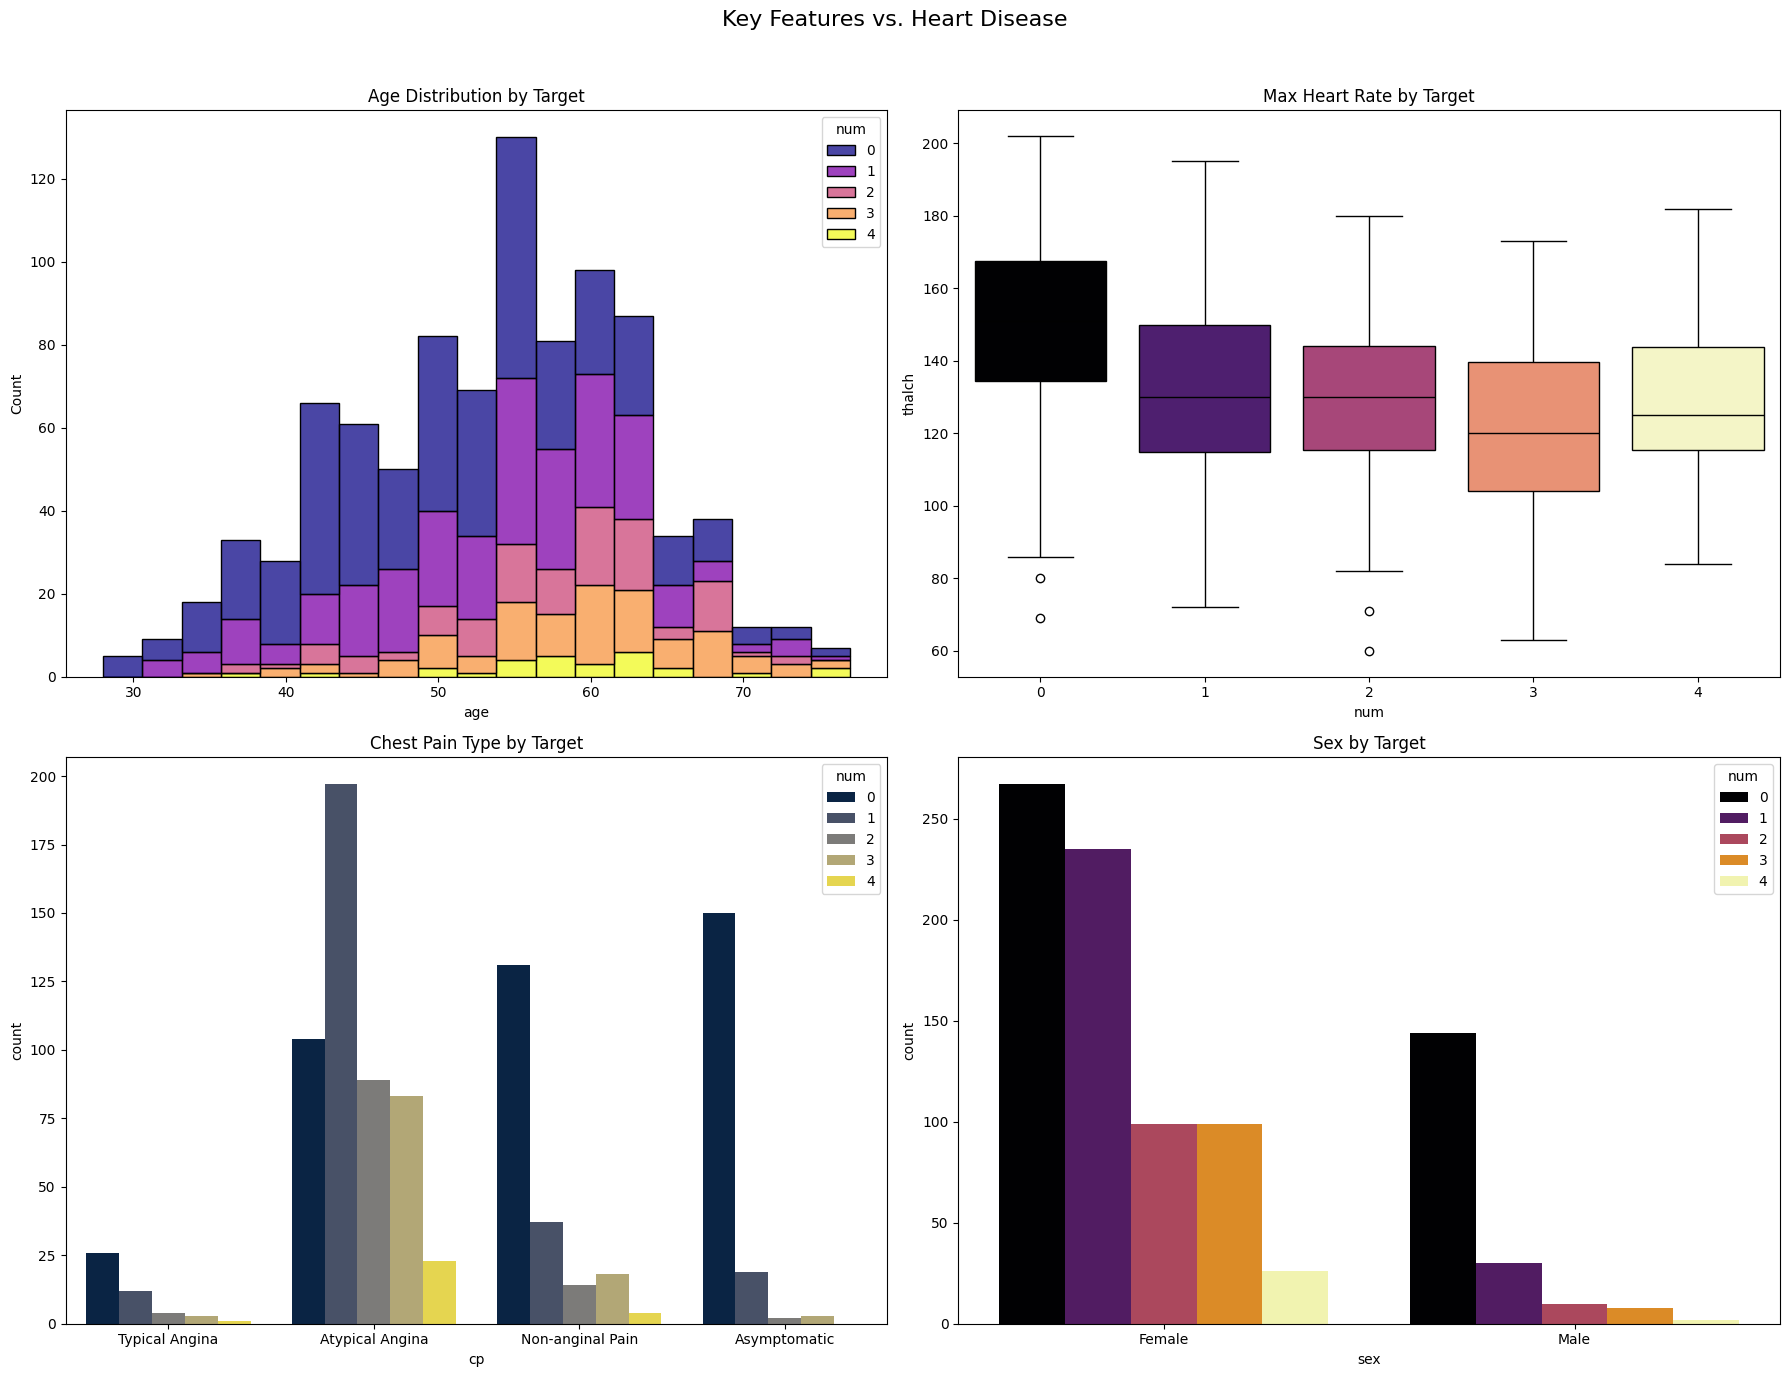

In [37]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Insights:**

**Max Heart Rate (thalach):** Patients with heart disease tend to have a lower maximum heart rate.

**Chest Pain (cp):** Patients with chest pain types 1 and 2 (Atypical and Non-anginal) are more likely to have heart disease. Surprisingly, those with type 0 (Typical Angina) are less likely, and those with asymptomatic pain (type 3) are very likely to have the disease.

**Sex:** A higher proportion of females in this dataset have heart disease compared to males.

**Correlation Heatmap**

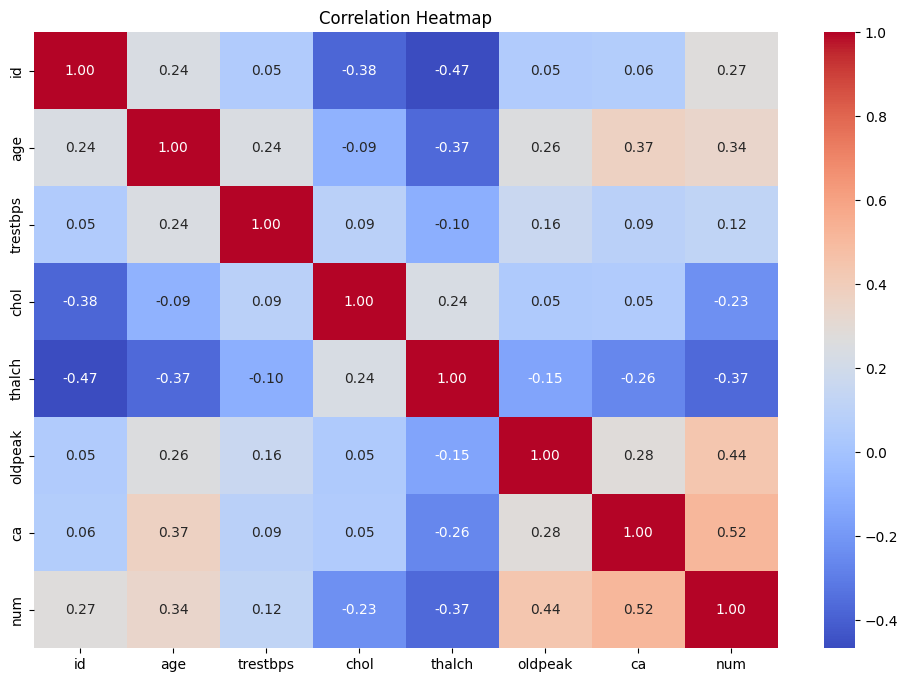

In [38]:
plt.figure(figsize=(12,8))
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# **Data Preprocessing (Manual)**

In [39]:
from sklearn.preprocessing import OneHotEncoder

# Separate features and target
X = df.drop("num", axis=1)
y = df["num"]

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)

# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Handle numerical features
num_imputer = SimpleImputer(strategy="mean")
X_num = num_imputer.fit_transform(X[numerical_features])

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

#Handle categorical features
cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat = cat_imputer.fit_transform(X[categorical_features])

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_cat)

#  Combine processed features
X_processed = np.hstack([X_num_scaled, X_cat_encoded])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)


print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Shapes:
X_train: (736, 25)
X_test: (184, 25)


# **Model Training (Without Pipelines)**

In [40]:
# Store results
results = []


def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    results.append([name, acc, prec, rec, f1])

    print(f"{name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))
    print("-" * 50)


# Logistic Regression
evaluate_model("Logistic Regression", LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test)

# Random Forest
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test)

# SVM
evaluate_model("SVM", SVC(kernel="rbf", probability=True, random_state=42), X_train, y_train, X_test, y_test)

# KNN
evaluate_model("KNN", KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test)

Logistic Regression:
  Accuracy:  0.5815
  Precision: 0.5523
  Recall:    0.5815
  F1 Score:  0.5615

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        82
           1       0.46      0.57      0.51        53
           2       0.30      0.14      0.19        22
           3       0.23      0.24      0.23        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.36      0.36      0.35       184
weighted avg       0.55      0.58      0.56       184

--------------------------------------------------
Random Forest:
  Accuracy:  0.5543
  Precision: 0.5028
  Recall:    0.5543
  F1 Score:  0.5260

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80        82
           1       0.47      0.55      0.50        53
           2       0.12      0.09      0.11        

**Accuracy:** (TP+TN) / Total. Overall, how often is the classifier correct?

**Precision:** TP / (TP+FP). Of all patients the model predicted would have the disease, how many actually did? (Measures the cost of FPs).

**Recall (Sensitivity):** TP / (TP+FN). Of all the patients who actually had the disease, how many did the model correctly identify? (Measures the cost of FNs).

**F1-Score:** The harmonic mean of Precision and Recall. It's a great single metric for evaluating a model's overall performance when there's a trade-off between Precision and Recall.

# **Model Comparison**

In [41]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.581522,0.552310,0.581522,0.561495
1,Random Forest,0.554348,0.502805,0.554348,0.526032
2,SVM,0.576087,0.524775,0.576087,0.544021
3,KNN,0.565217,0.512576,0.565217,0.535486


**Evaluation Insight:**
On this dataset, Logistic Regression performs the best with an accuracy of 0.58 and balanced F1-scores, especially for class 1 (Heart Disease). SVM and Random Forest also do reasonably well, though they struggle more with the less frequent classes. KNN lags slightly behind, making Logistic Regression the most reliable choice overall.

# **Conclusion**

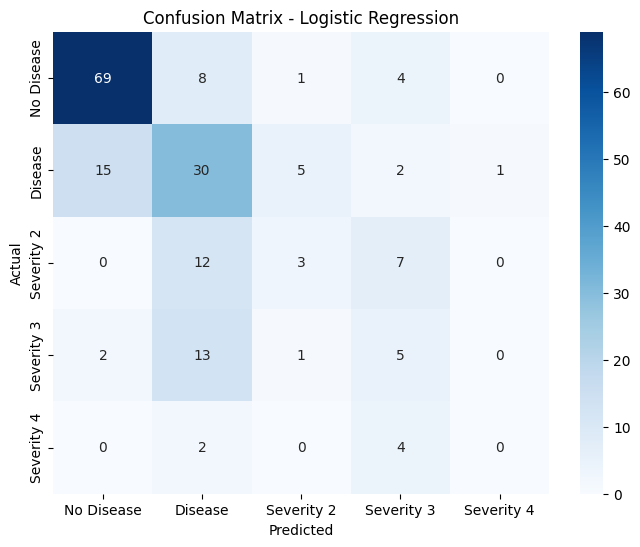

In [44]:
# Visualize the confusion matrix for the best model (Logistic Regression)
# Train Logistic Regression separately to get predictions
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'],
    yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()




# **Key Steps Undertaken:**
---

1. **Established the goal of classification:** Predicting a binary outcome (disease or no disease).
2. **Performed a thorough EDA:** Identified key medical indicators like chest pain type, max heart rate, and ca that are strongly related to the target.
3. **Trained and compared four models:** Evaluated Logistic Regression, Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN). The evaluation showed that the **Logistic Regression** performed slightly better than the other models in this analysis.
4. **Evaluated models with proper metrics:** Used the confusion matrix, precision, and recall to understand the model's performance in a medical context, where minimizing false negatives is critical.



